In [1]:
from math import nan
from pathlib import Path
import re
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
records = []
for design in sorted(Path(".").glob("??_*")):
    cosim_time = None
    for line in (design / "vitis_hls.log").read_text().splitlines():
        if line.startswith("INFO: [HLS 200-111] Finished Command cosim_design "):
            match = re.search(r"Elapsed time: (\d+.\d+) seconds", line)
            if match:
                cosim_time = float(match.group(1))
                break
    assert cosim_time is not None

    fe_compile_time = None
    mt_exec_time = None
    omnisim_cycles = None
    for line in (design / "omnisim.log").read_text().splitlines():
        if line.startswith("Front-end compilation time: "):
            fe_compile_time = float(
                line.removeprefix("Front-end compilation time: ").removesuffix(" seconds")
            )
            continue
        if line.startswith("Multi-threaded execution time: "):
            mt_exec_time = float(
                line.removeprefix("Multi-threaded execution time: ").removesuffix(" seconds")
            )
            continue
        if line.startswith("Took ") and line.endswith(" cycles"):
            omnisim_cycles = int(line.split()[1])
            continue
        if line == "unresolvable deadlock detected":
            omnisim_cycles = 0
            continue
    assert fe_compile_time is not None
    assert mt_exec_time is not None
    assert omnisim_cycles is not None

    with zipfile.ZipFile(design / "project/solution1/.autopilot/db/process_stalling_info/process.zip") as z:
        with z.open("module_status1.csv") as f:
            lines = f.read().decode().splitlines()
            cosim_cycles = int(lines[5])
            if cosim_cycles == 4294967295:
                cosim_cycles = 0

    records.append({
        "name": design.name.split("_", 1)[1],
        "cosim_time": cosim_time,
        "fe_compile_time": fe_compile_time,
        "mt_exec_time": mt_exec_time,
        "omnisim_cycles": omnisim_cycles,
        "cosim_cycles": cosim_cycles,
    })

df = pd.DataFrame.from_records(records)
df["cycle_percent_inaccuracy"] = (df["omnisim_cycles"] - df["cosim_cycles"]) / df["cosim_cycles"] * 100
df["omnisim_time"] = df["fe_compile_time"] + df["mt_exec_time"]
df["speedup"] = df["cosim_time"] / df["omnisim_time"]

In [9]:
df

,name,cosim_time,fe_compile_time,mt_exec_time,omnisim_cycles,cosim_cycles,cycle_percent_inaccuracy,omnisim_time,speedup
0,fig3_ex2,72.04,1.725833,0.413408,4057,4053,0.098692,2.139241,33.675495
1,fig3_ex3,66.51,1.735292,0.204823,4053,4051,0.049371,1.940115,34.281473
2,fig3_ex4a,70.74,1.725136,0.247570,2037,2037,0.000000,1.972706,35.859373
3,fig3_ex4a_d,70.05,1.752384,0.349511,2040,2036,0.196464,2.101895,33.327069
4,fig3_ex4b,70.80,1.786154,0.251942,2037,2037,0.000000,2.038096,34.738305
5,fig3_ex4b_d,70.66,1.758049,0.320482,2041,2039,0.098087,2.078531,33.995163
6,fig3_ex5,75.24,1.753140,0.346521,4060,4060,0.000000,2.099661,35.834356
7,fig2_timer,79.11,1.927649,1.786118,16202,16201,0.006172,3.713767,21.301821
8,deadlock,70.42,1.908086,0.508197,0,0,NaN,2.416283,29.143937
9,branch,65.86,1.608012,0.226190,960,958,0.208768,1.834202,35.906623


In [10]:
from scipy.stats import gmean
gmean(df["speedup"])

32.46712363911236

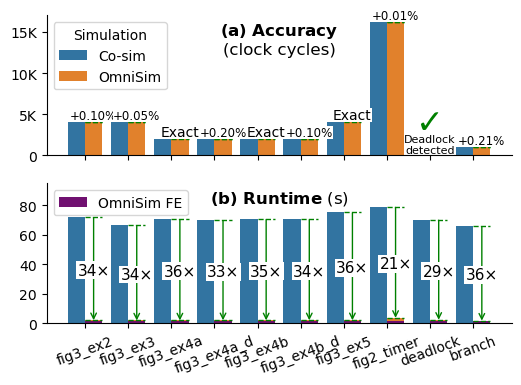

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
tidy = df.rename(columns={"name": "Design", "cosim_cycles": "Co-sim", "omnisim_cycles": "OmniSim"}).melt(id_vars=("Design",), value_vars=("Co-sim", "OmniSim")).rename(columns={"value": "Simulated clock cycles", "variable": "Simulation"})
sns.barplot(data=tidy, x="Design", y="Simulated clock cycles", hue="Simulation", ax=ax1)
sns.despine(fig)
ax1.tick_params(axis="x", rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1e3:.0f}K" if x != 0 else "0"))

for cosim_bar, omnisim_bar in zip(ax1.containers[0], ax1.containers[1]):
    x1 = omnisim_bar.get_x()
    w = omnisim_bar.get_width()
    x2 = x1 + w
    x = x1 + (w / 2)
    y1 = cosim_bar.get_height()
    y2 = omnisim_bar.get_height()
    y = (y1 + y2) / 2

    if y == 0:
        ax1.text(x1, 0, "Deadlock\ndetected", horizontalalignment="center", verticalalignment="bottom", fontsize=8)
        _, ckmk_loc = ax1.transData.inverted().transform(ax1.transData.transform((x1, 0)) + np.array([0, 16]))
        ax1.text(x1, ckmk_loc, "\u2713", color="green", horizontalalignment="center", verticalalignment="bottom", fontsize=24)
        continue

    lw = 1
    ax1.plot([x1, x2], [y1, y1], color="green", linestyle="--", lw=lw)

    if y1 == y2:
        ax1.text(x, y1, "Exact", horizontalalignment="center", verticalalignment="bottom", fontsize=10, bbox=dict(fc="white", pad=0, lw=0))
        continue

    ax1.plot([x1, x2], [y2, y2], color="green", linestyle="--", lw=lw)
    ax1.plot([x, x], [y1, y2], color="green", linestyle="-", lw=lw)
    ax1.text(x, y2, f"{(y2 - y1) / y1:+.2%}", horizontalalignment="center", verticalalignment="bottom", fontsize=8.5, bbox=dict(fc="white", pad=0, lw=0))

tidy1 = df.rename(columns={"name": "Design", "cosim_time": "Co-sim", "omnisim_time": "OmniSim MT"}).melt(id_vars=("Design",), value_vars=("Co-sim", "OmniSim MT")).rename(columns={"value": "Simulation runtime (s)", "variable": "Simulation"})
bar1 = sns.barplot(data=tidy1, x="Design", y="Simulation runtime (s)", hue="Simulation", ax=ax2)
tidy2 = df.rename(columns={"name": "Design", "fe_compile_time": "OmniSim FE"}).melt(id_vars=("Design",), value_vars=("OmniSim FE",)).rename(columns={"value": "Simulation runtime (s)", "variable": "Simulation"})
tidy2a = tidy2.copy()
tidy2a["Simulation"] = ""
tidy2a["Simulation runtime (s)"] = 0
tidy2 = pd.concat([tidy2a, tidy2])
bar2 = sns.barplot(data=tidy2, x="Design", y="Simulation runtime (s)", hue="Simulation", ax=ax2, palette="light:purple")
sns.despine(fig)
ax2.tick_params(axis="x", rotation=20)

for cosim_bar, omnisim_bar in zip(ax2.containers[0], ax2.containers[1]):
    x1 = omnisim_bar.get_x()
    w = omnisim_bar.get_width()
    x2 = x1 + w
    x = x1 + (w / 2)
    y1 = cosim_bar.get_height()
    y2 = omnisim_bar.get_height()
    y = (y1 + y2) / 2
    lw = 1
    ax2.plot([x1, x2], [y1, y1], color="green", linestyle="--", lw=lw)
    ax2.plot([x1, x2], [y2, y2], color="green", linestyle="--", lw=lw)
    ax2.annotate("", xytext=(x, y1), xy=(x, y2), arrowprops=dict(arrowstyle="->", shrinkA=lw / 2, shrinkB=0, color="green", lw=lw))
    ax2.text(x, y, f"{y1 / y2:.0f}\u00D7", fontsize=11, horizontalalignment="center", verticalalignment="center_baseline", bbox=dict(fc="white", pad=1, lw=0))

handles, labels = ax2.get_legend_handles_labels()
order = [2]
ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper left")
ax2.set_ylim(0, 95)

ax1.set_title("$\\bf(a)\\ Accuracy$\n(clock cycles)", y=1.0, pad=-28)
ax2.set_title("$\\bf(b)\\ Runtime$ (s)", y=1.0, pad=-14)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax2.set_xlabel("")
fig.savefig("experiments.pdf", bbox_inches="tight")

In [17]:
df["cycle_percent_inaccuracy"].mean()

0.05609828285960434

In [20]:
from scipy.stats import gmean
gmean(df["speedup"])

32.1058995642145

In [22]:
df.iloc[df["speedup"].argmax()]

name                        fig3_ex4a
cosim_time                      70.74
fe_compile_time              1.725136
mt_exec_time                  0.24757
omnisim_cycles                   2037
cosim_cycles                     2037
cycle_percent_inaccuracy          0.0
omnisim_time                 1.972706
speedup                     35.859373
Name: 2, dtype: object

In [23]:
lsv2_bench = [
    4.97,
    2.43,
    3.69,
    2.42,
    2.12,
    2.34,
    2.24,
    2.25,
    2.27,
    2.23,
    2.29,
    2.30,
    2.29,
    2.18,
    2.15,
    2.14,
    2.19,
    2.06,
    2.18,
    2.20,
    2.21,
    2.37,
    2.78,
    2.67,
    2.63,
    2.61,
    2.27,
    4.48,
    28.9,
    30.9,
    41.6,
    30.5,
    26.9,
    2.14*60,
    51.71*60,
]
assert len(lsv2_bench) == 35

In [24]:
lsv2_speedups = []
for i, lsv2_time in enumerate(lsv2_bench):
    design, = Path(f"..").glob(f"{i + 1:02d}_*")

    fe_compile_time = None
    mt_exec_time = None
    for line in (design / "omnisim.log").read_text().splitlines():
        if line.startswith("Front-end compilation time: "):
            fe_compile_time = float(
                line.removeprefix("Front-end compilation time: ").removesuffix(" seconds")
            )
            continue
        if line.startswith("Multi-threaded execution time: "):
            mt_exec_time = float(
                line.removeprefix("Multi-threaded execution time: ").removesuffix(" seconds")
            )
            continue
    assert fe_compile_time is not None
    assert mt_exec_time is not None

    def fmt(num: float):
        if num < 100:
            return f"{num:.2f}"
        return f"{num:.1f}"

    omnisim_time = fe_compile_time + mt_exec_time
    speedup = lsv2_time / omnisim_time
    print(f"{fmt(omnisim_time)} & {fmt(fe_compile_time)} & {fmt(mt_exec_time)} & {speedup:.2f}\\texttimes{{}} \\\\")
    lsv2_speedups.append(speedup)

3.65 & 3.42 & 0.23 & 1.36\texttimes{} \\
1.94 & 1.74 & 0.20 & 1.25\texttimes{} \\
3.15 & 2.77 & 0.38 & 1.17\texttimes{} \\
2.46 & 2.11 & 0.35 & 0.98\texttimes{} \\
2.03 & 1.81 & 0.22 & 1.04\texttimes{} \\
2.16 & 1.94 & 0.23 & 1.08\texttimes{} \\
2.13 & 1.91 & 0.23 & 1.05\texttimes{} \\
2.14 & 1.91 & 0.23 & 1.05\texttimes{} \\
2.12 & 1.90 & 0.22 & 1.07\texttimes{} \\
2.19 & 1.96 & 0.23 & 1.02\texttimes{} \\
2.20 & 1.98 & 0.22 & 1.04\texttimes{} \\
2.30 & 2.08 & 0.22 & 1.00\texttimes{} \\
2.19 & 1.95 & 0.24 & 1.05\texttimes{} \\
2.12 & 1.92 & 0.19 & 1.03\texttimes{} \\
2.13 & 1.94 & 0.19 & 1.01\texttimes{} \\
1.91 & 1.71 & 0.19 & 1.12\texttimes{} \\
2.07 & 1.90 & 0.17 & 1.06\texttimes{} \\
1.94 & 1.77 & 0.17 & 1.06\texttimes{} \\
2.08 & 1.87 & 0.21 & 1.05\texttimes{} \\
2.05 & 1.84 & 0.21 & 1.07\texttimes{} \\
2.05 & 1.85 & 0.19 & 1.08\texttimes{} \\
2.46 & 2.13 & 0.33 & 0.96\texttimes{} \\
2.91 & 2.28 & 0.63 & 0.95\texttimes{} \\
2.93 & 2.29 & 0.64 & 0.91\texttimes{} \\
2.32 & 1.99 & 0.

In [25]:
from scipy.stats import gmean
gmean(lsv2_speedups)

1.2611466476172273

In [ ]:
for design in sorted(Path(".").glob("??_*")):
    print(design.name)
    for line in (design / "vitis_hls.log").read_text().splitlines():
        if line.startswith("INFO: [HLS 200-111] Finished Command cosim_design "):
            match = re.search(r"Elapsed time: (\d+.\d+) seconds", line)
            if match:
                cosim_time = float(match.group(1))
                break